# **Train MetaA2C Model on Multi-Reversal ABC Task**

This notebook trains a Meta-Actor-Critic (MetaA2C) model on the multi-reversal ABC task where:
- Stimulus A: Rewarded in even phases (0, 2, 4, ...), never in odd phases (1, 3, 5, ...)
- Stimulus B: Never rewarded in even phases, rewarded in odd phases
- Stimulus C: Random reward (50% probability, doesn't reverse)

The MetaA2C model uses a shared RNN backbone with feedforward actor and critic heads, enabling the agent to maintain memory across timesteps and use previous actions and rewards as input.

Training approach:
- Train sequentially through multiple reversal phases
- Track metrics continuously across the entire sequence
- Visualise with multiple reversal points marked on the plots


In [2]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import pickle
import torch
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

# Add parent directory to path for imports
sys.path.append(str(Path.cwd().parent))

from cog_nn.tasks.reversal_envs import ReversalABCEnv, load_reversal_abc_multi_data
from cog_nn.models import RNNActorCritic
from cog_nn.agents import MetaA2CAgent

# Import plot style settings
import cog_nn.plot_style

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
save_path = Path("/Users/pmccarthy/Documents/modelling_results/december_2025_a2c/single_reversal")
task_data_path = Path("/Users/pmccarthy/Documents/cogNN/task_data")
task = "reversal_abc_multi"

---
Load Task Dataset


In [4]:
# Load multi-reversal ABC task data
data_path = Path(task_data_path, f"{task}.pkl")

try:
    state_sequence, reward_sequence, reversal_mask, phase_boundaries, state_map = load_reversal_abc_multi_data(data_path)
    print(f"Loaded data from {data_path}")
    print(f"State sequence shape: {state_sequence.shape}")
    print(f"Reward sequence shape: {reward_sequence.shape}")
    if phase_boundaries:
        print(f"Phase boundaries: {phase_boundaries}")
        print(f"Reversal points (timesteps): {phase_boundaries.get('reversal_points', [])}")
except FileNotFoundError:
    print(f"Data file not found at {data_path}")
    print("Please run task_generation.ipynb first to generate the data")
    raise

# Create environment
env = ReversalABCEnv(
    state_sequence, 
    reward_sequence, 
    reversal_mask,
    reward_lick=1.0,      # Higher reward for correct lick
    lick_no_reward=-0.5,  # Less negative for incorrect lick
    no_lick=0.0           # No change for no lick
)
# Get state and action sizes
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print(f"\nEnvironment created:")
print(f"State size: {state_size}")
print(f"Action size: {action_size}")
print(f"Total timesteps: {len(state_sequence)}")

Loaded data from /Users/pmccarthy/Documents/cogNN/task_data/reversal_abc_multi.pkl
State sequence shape: (8000, 5)
Reward sequence shape: (8000,)
Phase boundaries: {'reversal_points': [2000, 4000, 6000], 'phase_0': {'start': 0, 'end': 2000}, 'phase_1': {'start': 2000, 'end': 4000}, 'phase_2': {'start': 4000, 'end': 6000}, 'phase_3': {'start': 6000, 'end': 8000}}
Reversal points (timesteps): [2000, 4000, 6000]

Environment created:
State size: 5
Action size: 2
Total timesteps: 8000


In [5]:
phase_boundaries

{'reversal_points': [2000, 4000, 6000],
 'phase_0': {'start': 0, 'end': 2000},
 'phase_1': {'start': 2000, 'end': 4000},
 'phase_2': {'start': 4000, 'end': 6000},
 'phase_3': {'start': 6000, 'end': 8000}}

---
Define Model and Agent


In [6]:
# Model hyperparameters
hidden_size = 128  # RNN hidden size
learning_rate = 0.0005
gamma = 0  # Discount factor

# Create MetaA2C agent (includes shared RNN backbone with actor and critic heads)
agent = MetaA2CAgent(state_size=state_size, action_size=action_size, hidden_size=hidden_size)

# Add optimizer and gamma to the model (required by update method)
agent.model.optimizer = Adam(agent.model.parameters(), lr=learning_rate)
agent.model.gamma = gamma

print("Model initialised:")
print(f"Gamma (discount factor): {agent.model.gamma}")
print(f"MetaA2C Agent: {agent.model}")

policy_clip_param = 0.25  # Minimum action probability


Models initialized:
Actor: Actor(
  (fc1): Linear(in_features=5, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=2, bias=True)
  (softmax): Softmax(dim=-1)
)
Critic: Critic(
  (fc1): Linear(in_features=5, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)


---
Training Setup


In [7]:
phase_boundaries

{'reversal_points': [2000, 4000, 6000],
 'phase_0': {'start': 0, 'end': 2000},
 'phase_1': {'start': 2000, 'end': 4000},
 'phase_2': {'start': 4000, 'end': 6000},
 'phase_3': {'start': 6000, 'end': 8000}}

In [8]:
# Training parameters
batch_size = 1  # Update every N steps

# Get phase boundaries for multi-reversal
if phase_boundaries:
    # Extract all phases from phase_boundaries
    phases = []
    reversal_points = phase_boundaries.get('reversal_points', [])
    
    # Find all phase_X keys
    phase_keys = [k for k in phase_boundaries.keys() if k.startswith('phase_')]
    phase_keys.sort(key=lambda x: int(x.split('_')[1]))  # Sort by phase number
    
    for phase_key in phase_keys:
        phases.append(phase_boundaries[phase_key])
    
    print(f"Training setup:")
    print(f"Number of phases: {len(phases)}")
    for i, phase in enumerate(phases):
        phase_type = "A rewarded" if i % 2 == 0 else "B rewarded"
        print(f"  Phase {i} ({phase_type}): timesteps {phase['start']} to {phase['end']}")
    print(f"Reversal points: {reversal_points}")
else:
    # Fallback: estimate from reversal_mask
    unique_phases = np.unique(reversal_mask)
    phases = []
    reversal_points = []
    for i, phase_val in enumerate(unique_phases):
        phase_mask = reversal_mask == phase_val
        phase_start = np.where(phase_mask)[0][0] * 2  # Each trial = 2 timesteps
        phase_end = (np.where(phase_mask)[0][-1] + 1) * 2
        phases.append({"start": phase_start, "end": phase_end})
        if i > 0:
            reversal_points.append(phase_start)

# Track metrics during training (continuous across sequence)
metrics = {
    'lick_probs': {'A': [], 'B': [], 'C': []},
    'values': {'A': [], 'B': [], 'C': []},
    'rewards': [],
    'timesteps': [],
    'reward_timesteps': [],
    'timesteps_A': [],
    'timesteps_B': [],
    'timesteps_C': []
}

Training setup:
Number of phases: 4
  Phase 0 (A rewarded): timesteps 0 to 2000
  Phase 1 (B rewarded): timesteps 2000 to 4000
  Phase 2 (A rewarded): timesteps 4000 to 6000
  Phase 3 (B rewarded): timesteps 6000 to 8000
Reversal points: [2000, 4000, 6000]


---
Training Loop


In [9]:
# Set model to training mode
agent.model.train()

# Initialize previous action and reward tracking
prev_action = torch.zeros(action_size)  # One-hot encoding
prev_reward = torch.tensor(0.0)

# Reset hidden state
agent.reset_hidden_state()

# Reset environment
obs, info = env.reset()

# Track states, actions, rewards for batch update
states_batch = []
prev_actions_batch = []
prev_rewards_batch = []
actions_batch = []
rewards_batch = []
next_states_batch = []
next_prev_actions_batch = []
next_prev_rewards_batch = []
dones_batch = []

print("Starting training...")

# Train sequentially through all phases
for phase_idx, phase in enumerate(phases):
    phase_start = phase['start']
    phase_end = phase['end']
    phase_type = "A rewarded" if phase_idx % 2 == 0 else "B rewarded"
    
    print(f"\nPhase {phase_idx + 1}/{len(phases)} ({phase_type}): timesteps {phase_start} to {phase_end}")
    
    # Train on this phase
    for t_idx in range(phase_start, phase_end):
        if (t_idx - phase_start) % 50 == 0:
            print(f"  Timestep {t_idx}/{phase_end}")
        
        # Get current state
        state = torch.from_numpy(obs).float()
        
        # Select action (MetaA2C requires prev_action and prev_reward)
        action, action_prob, value = agent.select_action(state, prev_action, prev_reward, deterministic=False, policy_clip=policy_clip_param)
        
        # Step environment
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # Get actual environment timestep (absolute timestep in overall sequence)
        env_timestep = info.get('timestep', t_idx)
        
        # Store for batch update
        states_batch.append(obs)
        prev_actions_batch.append(prev_action.numpy())
        prev_rewards_batch.append(prev_reward.item())
        actions_batch.append(action)
        rewards_batch.append(reward)
        next_states_batch.append(next_obs)
        # Create next prev_action (one-hot) and prev_reward
        next_prev_action = torch.zeros(action_size)
        next_prev_action[action] = 1.0
        next_prev_actions_batch.append(next_prev_action.numpy())
        next_prev_rewards_batch.append(reward)
        dones_batch.append(done)
        
        # Track metrics by stimulus
        state_idx = np.argmax(obs)
        if state_map:
            state_idx_A = state_map.get('A', 0)
            state_idx_B = state_map.get('B', 1)
            state_idx_C = state_map.get('C', 2)
        else:
            state_idx_A, state_idx_B, state_idx_C = 0, 1, 2
        
        if state_idx == state_idx_A:  # A
            if action == 0:  # lick
                metrics['lick_probs']['A'].append(action_prob)
            elif action == 1:  # no-lick
                metrics['lick_probs']['A'].append(1 - action_prob)
            metrics['values']['A'].append(value)
            metrics['timesteps_A'].append(env_timestep)
        elif state_idx == state_idx_B:  # B
            if action == 0:  # lick
                metrics['lick_probs']['B'].append(action_prob)
            elif action == 1:  # no-lick
                metrics['lick_probs']['B'].append(1 - action_prob)
            metrics['values']['B'].append(value)
            metrics['timesteps_B'].append(env_timestep)
        elif state_idx == state_idx_C:  # C
            if action == 0:  # lick
                metrics['lick_probs']['C'].append(action_prob)
            elif action == 1:  # no-lick
                metrics['lick_probs']['C'].append(1 - action_prob)
            metrics['values']['C'].append(value)
            metrics['timesteps_C'].append(env_timestep)
        
        # Track rewards only when reward is available
        if info.get('reward_available', False):
            metrics['rewards'].append(reward)  # Actual reward from env.step()
            metrics['reward_timesteps'].append(env_timestep)
        
        obs = next_obs
        
        # Update prev_action and prev_reward for next iteration
        prev_action = next_prev_action
        prev_reward = torch.tensor(reward, dtype=torch.float32)
        
        # Batch update
        if len(states_batch) >= batch_size:
            agent.update(
                torch.from_numpy(np.array(states_batch)).float(),
                torch.from_numpy(np.array(prev_actions_batch)).float(),
                torch.from_numpy(np.array(prev_rewards_batch)).float(),
                torch.from_numpy(np.array(actions_batch)).long(),
                torch.from_numpy(np.array(rewards_batch)).float(),
                torch.from_numpy(np.array(next_states_batch)).float(),
                torch.from_numpy(np.array(next_prev_actions_batch)).float(),
                torch.from_numpy(np.array(next_prev_rewards_batch)).float(),
                torch.from_numpy(np.array(dones_batch)).float()
            )
            # Clear batch
            states_batch = []
            prev_actions_batch = []
            prev_rewards_batch = []
            actions_batch = []
            rewards_batch = []
            next_states_batch = []
            next_prev_actions_batch = []
            next_prev_rewards_batch = []
            dones_batch = []

# Final update with remaining batch
if len(states_batch) > 0:
    agent.update(
        torch.from_numpy(np.array(states_batch)).float(),
        torch.from_numpy(np.array(prev_actions_batch)).float(),
        torch.from_numpy(np.array(prev_rewards_batch)).float(),
        torch.from_numpy(np.array(actions_batch)).long(),
        torch.from_numpy(np.array(rewards_batch)).float(),
        torch.from_numpy(np.array(next_states_batch)).float(),
        torch.from_numpy(np.array(next_prev_actions_batch)).float(),
        torch.from_numpy(np.array(next_prev_rewards_batch)).float(),
        torch.from_numpy(np.array(dones_batch)).float()
    )

print("\nTraining complete!")
total_timesteps = sum(phase['end'] - phase['start'] for phase in phases)
print(f"Total timesteps trained: {total_timesteps}")
print(f"Total rewards collected: {len(metrics['rewards'])}")


Starting training...

Phase 1/4 (A rewarded): timesteps 0 to 2000
  Timestep 0/2000
  Timestep 50/2000
  Timestep 100/2000
  Timestep 150/2000
  Timestep 200/2000
  Timestep 250/2000
  Timestep 300/2000
  Timestep 350/2000
  Timestep 400/2000
  Timestep 450/2000
  Timestep 500/2000
  Timestep 550/2000
  Timestep 600/2000
  Timestep 650/2000
  Timestep 700/2000
  Timestep 750/2000
  Timestep 800/2000
  Timestep 850/2000
  Timestep 900/2000
  Timestep 950/2000
  Timestep 1000/2000
  Timestep 1050/2000
  Timestep 1100/2000
  Timestep 1150/2000
  Timestep 1200/2000
  Timestep 1250/2000
  Timestep 1300/2000
  Timestep 1350/2000
  Timestep 1400/2000
  Timestep 1450/2000
  Timestep 1500/2000
  Timestep 1550/2000
  Timestep 1600/2000
  Timestep 1650/2000
  Timestep 1700/2000
  Timestep 1750/2000
  Timestep 1800/2000
  Timestep 1850/2000
  Timestep 1900/2000
  Timestep 1950/2000

Phase 2/4 (B rewarded): timesteps 2000 to 4000
  Timestep 2000/4000
  Timestep 2050/4000
  Timestep 2100/4000
  Time

In [10]:
# Verify reward delivery logic
print("\n=== Reward Delivery Verification ===")
# Check: rewards are tracked at timesteps where reward is available
rewards_array = np.array(metrics['rewards'])

# Rewards are tracked when reward_available=True, storing actual reward from env.step()
print(f"Total rewards tracked (at available timesteps): {len(rewards_array)}")
print(f"Mean reward: {np.mean(rewards_array):.4f}")
print(f"Max reward: {np.max(rewards_array):.4f}")
print(f"Min reward: {np.min(rewards_array):.4f}")

# Check reward availability in sequence
if 'reward_sequence' in locals():
    # Count rewards available at outcome states (odd indices)
    reward_available_count = np.sum(reward_sequence[1::2] > 0)
    print(f"\nReward available at {reward_available_count} outcome states (odd timesteps)")
    print(f"Rewards tracked: {len(rewards_array)}")
    print(f"\nNote: Rewards are tracked at timesteps where reward is available.")
    print(f"The stored reward value is the actual reward output by env.step()")
    print(f"(which may be positive if agent licked, negative if agent licked but no reward, or 0 if no lick).")



=== Reward Delivery Verification ===
Total rewards tracked (at available timesteps): 2009
Mean reward: 0.8502
Max reward: 1.0000
Min reward: 0.0000

Reward available at 2009 outcome states (odd timesteps)
Rewards tracked: 2009

Note: Rewards are tracked at timesteps where reward is available.
The stored reward value is the actual reward output by env.step()
(which may be positive if agent licked, negative if agent licked but no reward, or 0 if no lick).


---
Visualise Results


In [ ]:
# Create save directory if it doesn't exist
save_path.mkdir(parents=True, exist_ok=True)
# Save trained model
torch.save(agent.model.state_dict(), save_path / "meta_a2c_multireversal_abc.pth")
# Save params
params = {
    "hidden_size": hidden_size,
    "learning_rate": learning_rate,
    "gamma": gamma,
    "batch_size": batch_size,
    "state_map": state_map,
}
with open(save_path / "meta_a2c_multireversal_abc_params.pkl", "wb") as f:
    pickle.dump(params, f)
print(f"\nModels and parameters saved to {save_path}")


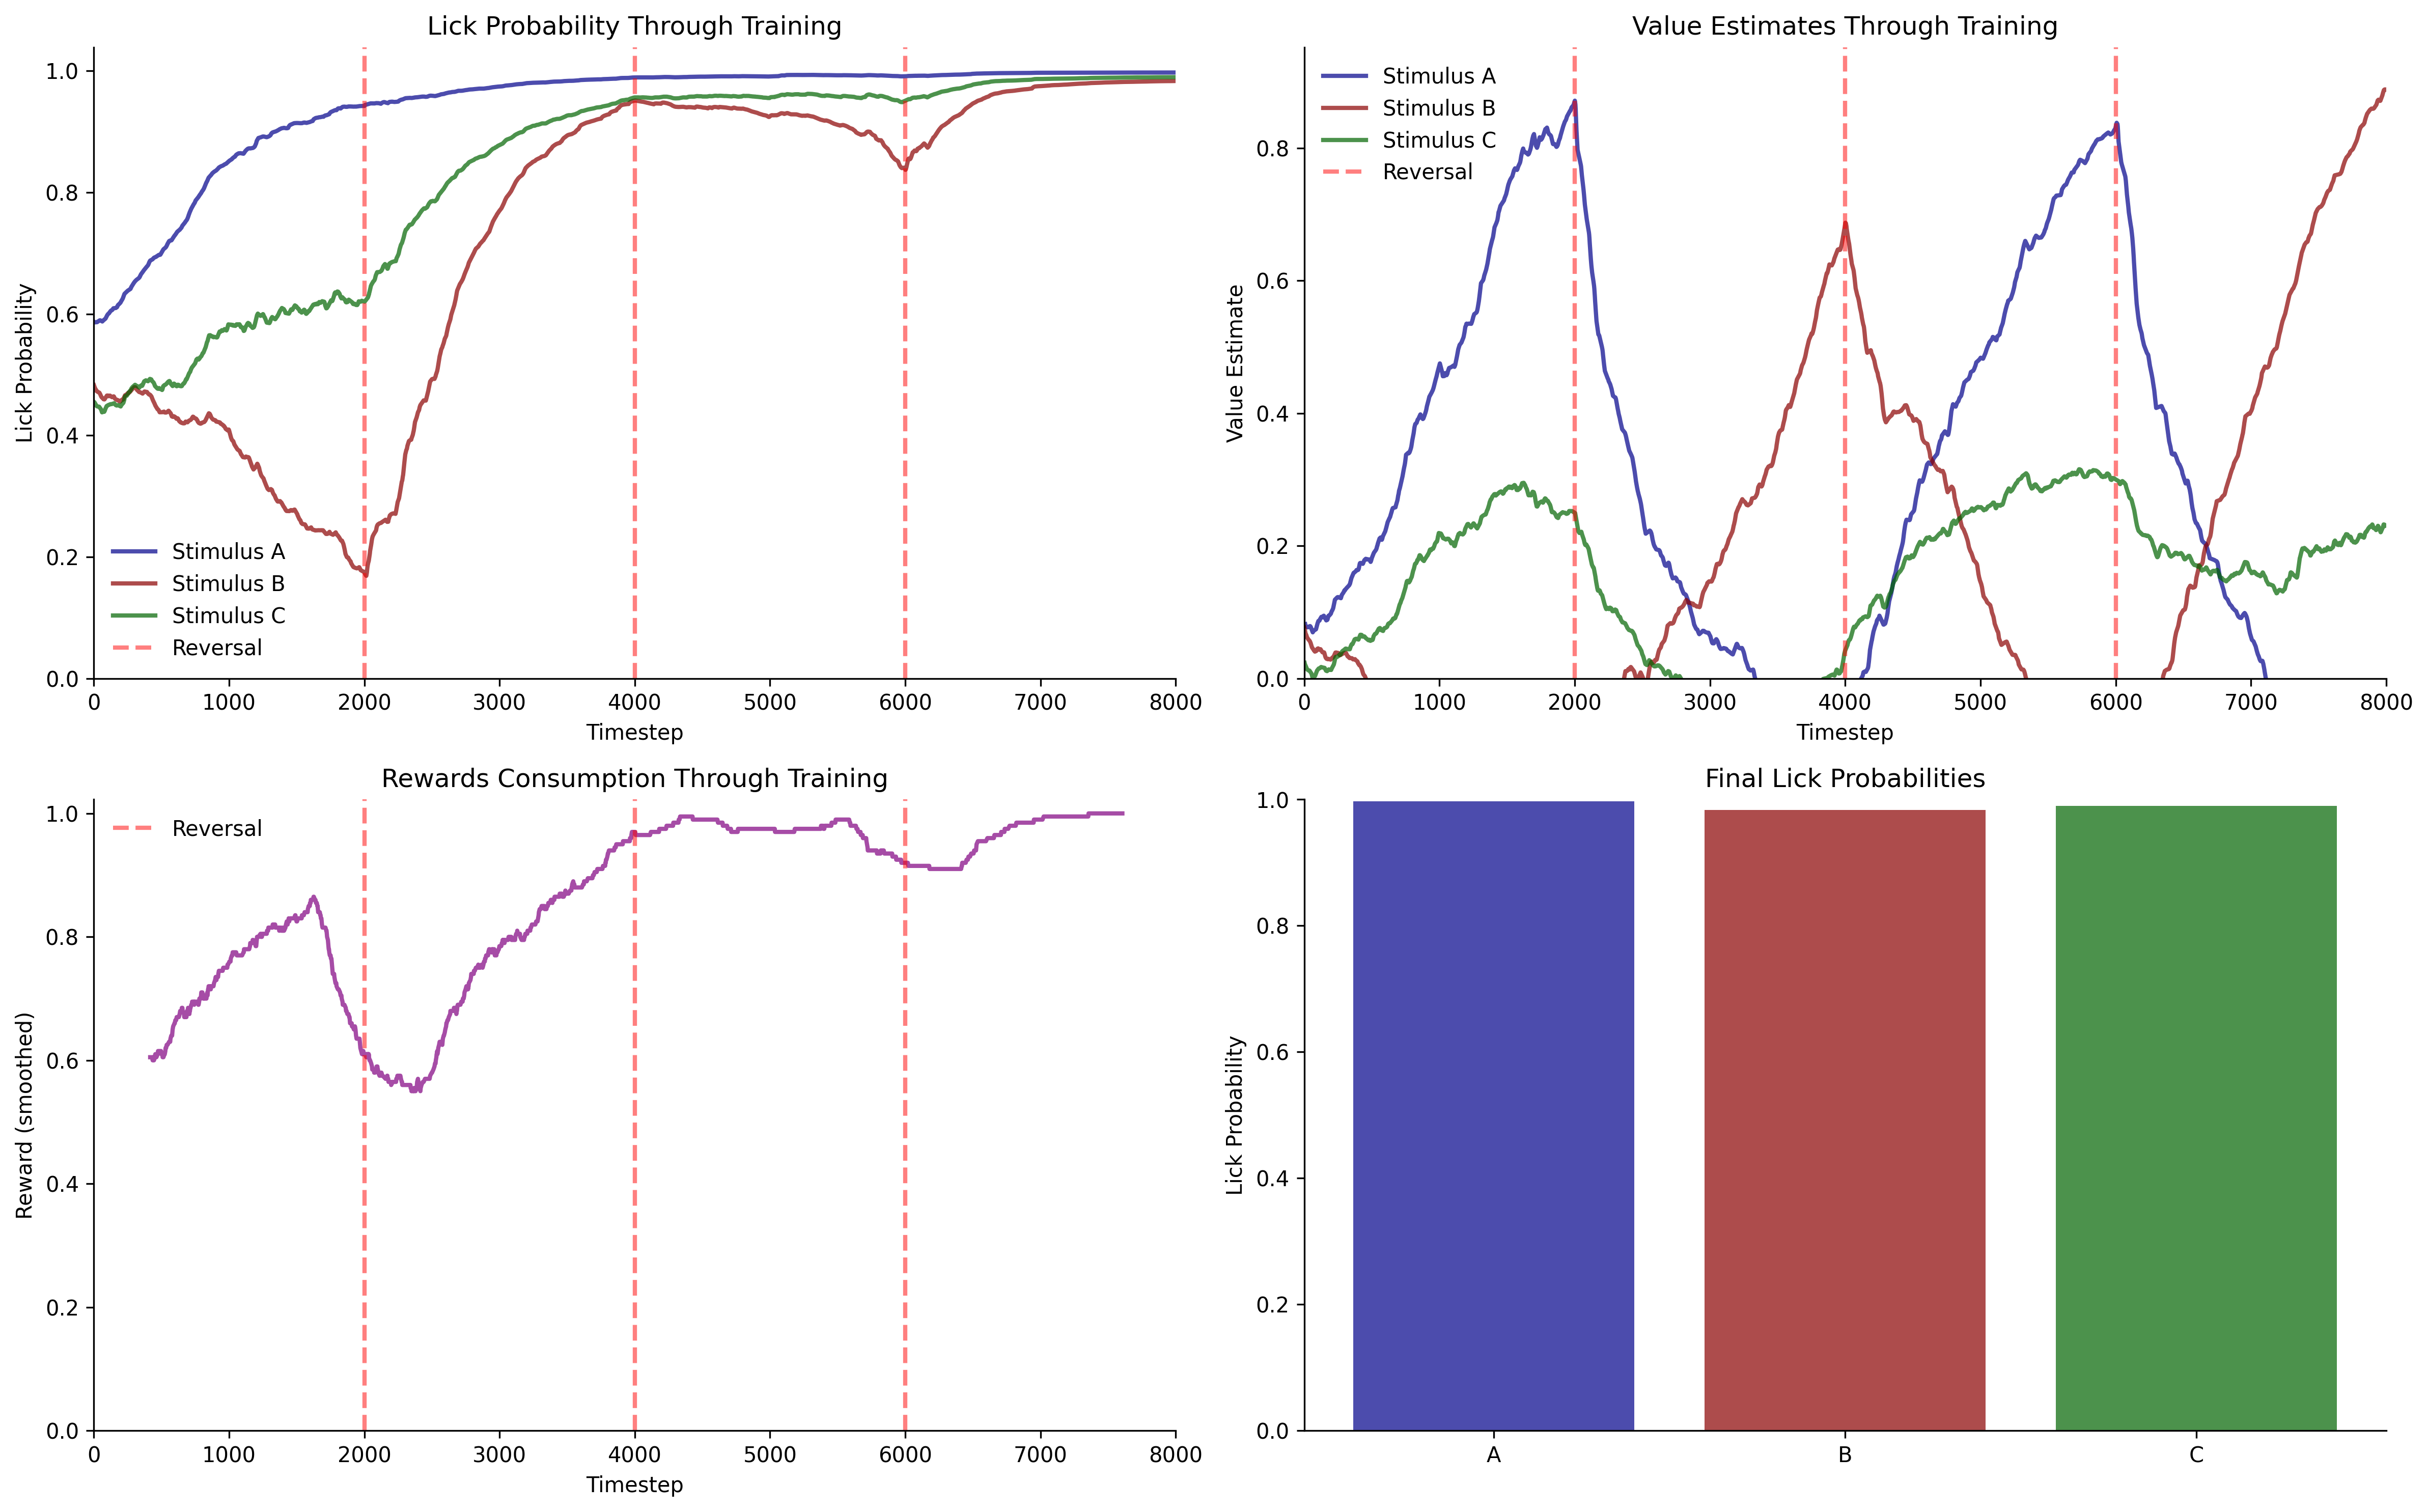

Visualisation complete!

Summary:
Mean reward: 0.8502
Final lick prob A: 0.997
Final lick prob B: 0.983
Final lick prob C: 0.990


In [11]:
# Convert metrics to numpy arrays
lick_probs_A = np.array(metrics['lick_probs']['A'])
lick_probs_B = np.array(metrics['lick_probs']['B'])
lick_probs_C = np.array(metrics['lick_probs']['C'])
values_A = np.array(metrics['values']['A'])
values_B = np.array(metrics['values']['B'])
values_C = np.array(metrics['values']['C'])
rewards = np.array(metrics['rewards'])

# Get timesteps for plotting
# Get timesteps for plotting (absolute timesteps from overall sequence)
timesteps_A = np.array(metrics.get('timesteps_A', []))
timesteps_B = np.array(metrics.get('timesteps_B', []))
timesteps_C = np.array(metrics.get('timesteps_C', []))

# Create visualisations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Lick probabilities over training (with reversal points)
ax = axes[0, 0]
if len(timesteps_A) == len(lick_probs_A) and len(timesteps_A) > 0:
    ax.plot(timesteps_A, lick_probs_A, label='Stimulus A', linewidth=2, color='darkblue', alpha=0.7)
if len(timesteps_B) == len(lick_probs_B) and len(timesteps_B) > 0:
    ax.plot(timesteps_B, lick_probs_B, label='Stimulus B', linewidth=2, color='darkred', alpha=0.7)
if len(timesteps_C) == len(lick_probs_C) and len(timesteps_C) > 0:
    ax.plot(timesteps_C, lick_probs_C, label='Stimulus C', linewidth=2, color='darkgreen', alpha=0.7)

# Mark reversal points
# Get reversal points from phase_boundaries
reversal_points = phase_boundaries.get('reversal_points', []) if phase_boundaries else []
for rev_point in reversal_points:
    ax.axvline(x=rev_point, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Reversal' if rev_point == reversal_points[0] else '')

ax.set_xlabel('Timestep')
ax.set_ylabel('Lick Probability')
ax.set_title('Lick Probability Through Training')
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlim(0, len(state_sequence))

# Plot 2: Value estimates over training
ax = axes[0, 1]
if len(timesteps_A) == len(values_A) and len(timesteps_A) > 0:
    ax.plot(timesteps_A, values_A, label='Stimulus A', linewidth=2, color='darkblue', alpha=0.7)
if len(timesteps_B) == len(values_B) and len(timesteps_B) > 0:
    ax.plot(timesteps_B, values_B, label='Stimulus B', linewidth=2, color='darkred', alpha=0.7)
if len(timesteps_C) == len(values_C) and len(timesteps_C) > 0:
    ax.plot(timesteps_C, values_C, label='Stimulus C', linewidth=2, color='darkgreen', alpha=0.7)

# Mark reversal points
# Get reversal points from phase_boundaries
reversal_points = phase_boundaries.get('reversal_points', []) if phase_boundaries else []
for rev_point in reversal_points:
    ax.axvline(x=rev_point, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Reversal' if rev_point == reversal_points[0] else '')

ax.set_xlabel('Timestep')
ax.set_ylabel('Value Estimate')
ax.set_title('Value Estimates Through Training')
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlim(0, len(state_sequence))

# Plot 3: Rewards over time (smoothed)
# Get reward timesteps
reward_timesteps = np.array(metrics.get('reward_timesteps', np.arange(len(rewards))))
ax = axes[1, 0]
# Smooth rewards with moving average
window_size = 200
if len(rewards) > window_size:
    smoothed_rewards = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
    # Get reward timesteps
    reward_timesteps = np.array(metrics.get('reward_timesteps', np.arange(len(rewards))))
    # For mode='valid', np.convolve returns len(rewards) - window_size + 1 elements
    # The smoothed values correspond to timesteps starting from window_size//2
    start_idx = window_size // 2
    smoothed_timesteps = reward_timesteps[start_idx:start_idx + len(smoothed_rewards)]
    ax.plot(smoothed_timesteps, smoothed_rewards, linewidth=2, color='purple', alpha=0.7)
else:
    ax.plot(rewards, linewidth=1, color='purple', alpha=0.5)

# Mark reversal points
# Get reversal points from phase_boundaries
reversal_points = phase_boundaries.get('reversal_points', []) if phase_boundaries else []
for rev_point in reversal_points:
    ax.axvline(x=rev_point, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Reversal' if rev_point == reversal_points[0] else '')

ax.set_xlabel('Timestep')
ax.set_ylabel('Reward (smoothed)')
ax.set_title('Rewards Consumption Through Training')
ax.legend()
ax.set_ylim(bottom=0)
ax.set_xlim(0, len(state_sequence))

# Plot 4: Final performance comparison
ax = axes[1, 1]
# Get final values for each stimulus
final_lick_probs = []
stimuli = []
colors = []
if len(lick_probs_A) > 0:
    final_lick_probs.append(lick_probs_A[-1])
    stimuli.append('A')
    colors.append('darkblue')
if len(lick_probs_B) > 0:
    final_lick_probs.append(lick_probs_B[-1])
    stimuli.append('B')
    colors.append('darkred')
if len(lick_probs_C) > 0:
    final_lick_probs.append(lick_probs_C[-1])
    stimuli.append('C')
    colors.append('darkgreen')

if len(final_lick_probs) > 0:
    bars = ax.bar(stimuli, final_lick_probs, color=colors, alpha=0.7)
    ax.set_ylabel('Lick Probability')
    ax.set_title('Final Lick Probabilities')
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("Visualisation complete!")
print(f"\nSummary:")
print(f"Mean reward: {np.mean(rewards):.4f}")
if len(lick_probs_A) > 0:
    print(f"Final lick prob A: {lick_probs_A[-1]:.3f}")
if len(lick_probs_B) > 0:
    print(f"Final lick prob B: {lick_probs_B[-1]:.3f}")
if len(lick_probs_C) > 0:
    print(f"Final lick prob C: {lick_probs_C[-1]:.3f}")